# Robust Asset Allocation (RAA)

## Colaboratory Imports for Backtests

In [3]:
# only for colaboratory

!pip install git+https://github.com/scubamut/fintools.git
!pip install cvxopt
!pip install pyfolio
!pip install ffn
!pip install itable
!pip install git+https://github.com/pydata/pandas-datareader.git

## Imports for Backtests

In [3]:
from __future__ import print_function
from IPython.utils.path import get_ipython_dir
print(get_ipython().profile_dir.location)
 
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import talib
import itable
import ffn
 
from fintools.Parameters import Parameters
from fintools.set_start_end import set_start_end
from fintools.get_yahoo_prices import get_yahoo_prices
from fintools.compute_weights_RS_DM import compute_weights_RS_DM
from fintools.compute_weights_PMA import compute_weights_PMA
from fintools.endpoints import endpoints
from fintools.backtest import backtest
from fintools.monthly_return_table import monthly_return_table
from fintools.show_return_table import show_return_table
from fintools.finhelpers3 import highlight_pos_neg
 
%matplotlib inline

/home/scubamut/.ipython/profile_default


# RAAB000

## Symbols

In [4]:
symbols =['MTUM','IWD','EFA','EFV','VNQ','DBC','IEF']
cash_proxy = 'CASHX'
risk_free = 'BIL'

# get data
tickers = symbols.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))

## Variables

In [5]:
rs_lookback = 12
risk_lookback = 12
n_top = 7



# Define which online source one should use
data_source = 'yahoo'

start_date = '2000-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# chosen from one of 
data_column = 'Adj Close'

data_path = '/home/scubamut/Projects/DATA/'

## Data

In [6]:
# User pandas_reader.data.DataReader to load MultiIndex Data.
MI_data = web.DataReader(tickers, data_source, start_date, end_date)
data = MI_data[data_column].sort_index(ascending=True)

### Clean Data

In [7]:
inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])
print (inception_dates)   

         inception
Symbols           
BIL     2007-05-30
DBC     2006-02-06
EFA     2001-08-27
EFV     2005-08-05
IEF     2002-07-30
IWD     2000-05-26
MTUM    2013-04-18
VNQ     2004-09-29


### make sure there is no missing data

In [8]:
# make sure there is no missing data (nan)
# and, if so, save csv

for col in data.columns:
    df = data[col]
    print (col, data[col].first_valid_index(),
           len(data[col].dropna()),
           len(df[data[col].first_valid_index():]) == len(data[col].dropna()))
    if len(df[data[col].first_valid_index():]) == len(data[col].dropna()):
        data[col].dropna().to_csv(data_path + col + '.csv')
    else:
        print ('***********************')
 

BIL 2007-05-30 00:00:00 2812 True
DBC 2006-02-06 00:00:00 3141 True
EFA 2001-08-27 00:00:00 4256 True
EFV 2005-08-05 00:00:00 3267 True
IEF 2002-07-30 00:00:00 4028 True
IWD 2000-05-26 00:00:00 4571 True
MTUM 2013-04-18 00:00:00 1330 True
VNQ 2004-09-29 00:00:00 3482 True


In [9]:
def get_date(timestamp):
    return (str(timestamp.year) + '-' + str(timestamp.month) + '-' + str(timestamp.day))

prices = data.copy().dropna()
start_date = get_date(prices.index[0].date())
end_date = get_date(prices.index[-1].date())

print('start_date=' , start_date, 'end_date=', end_date)

start_date= 2013-4-18 end_date= 2018-7-27


FIRST BUY DATE = 2014-04-30 00:00:00



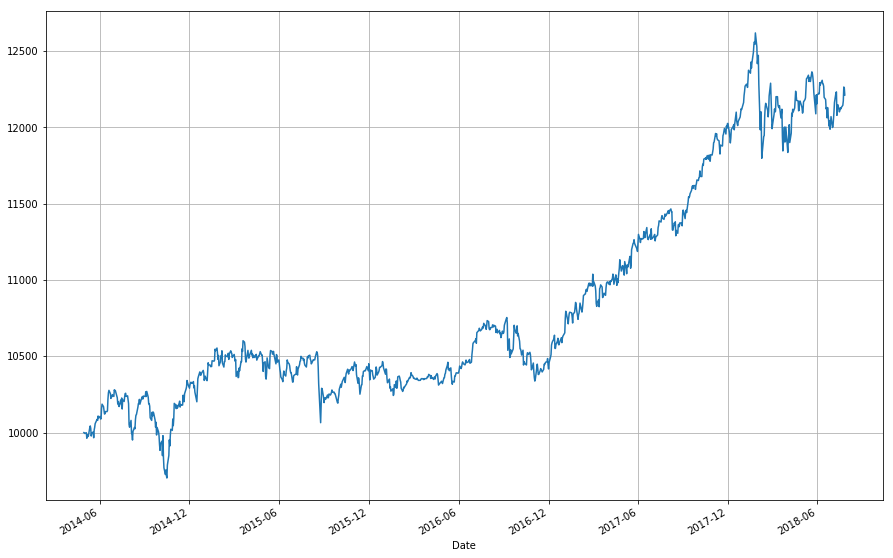

In [10]:
end_points = endpoints(period='M', trading_days=prices.index)
prices_m = prices.loc[end_points]

returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
absolute_momentum_rule = returns > 0

if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking               
ranked = excess_returns.loc[rebalance_dates][symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

In [11]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 2014-04-30 00:00:00 - 2018-07-27 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
22.13%              0.81  4.83%   -6.51%

Annualized Returns:
mtd    3m     6m      ytd    1y     3y     5y     10y    incep.
-----  -----  ------  -----  -----  -----  -----  -----  --------
1.17%  0.33%  -3.23%  0.79%  6.95%  5.40%  4.83%  4.83%  4.83%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.81     1.08       0.68
mean    4.90%    4.81%      4.39%
vol     6.04%    4.44%      6.42%
skew    -0.73    -0.75      1.96
kurt    3.98     0.27       3.84
best    1.33%    2.75%      13.99%
worst   -2.44%   -2.90%     0.79%

Drawdowns:
max     avg       # days
------  ------  --------
-6.51%  -0.76%     22.62

Misc:
---------------  -------
avg. up month    1.08%
avg. down month  -1.08%
up year %        100.00%
12m up %         87.80%
----

In [12]:
show_return_table(p_value)

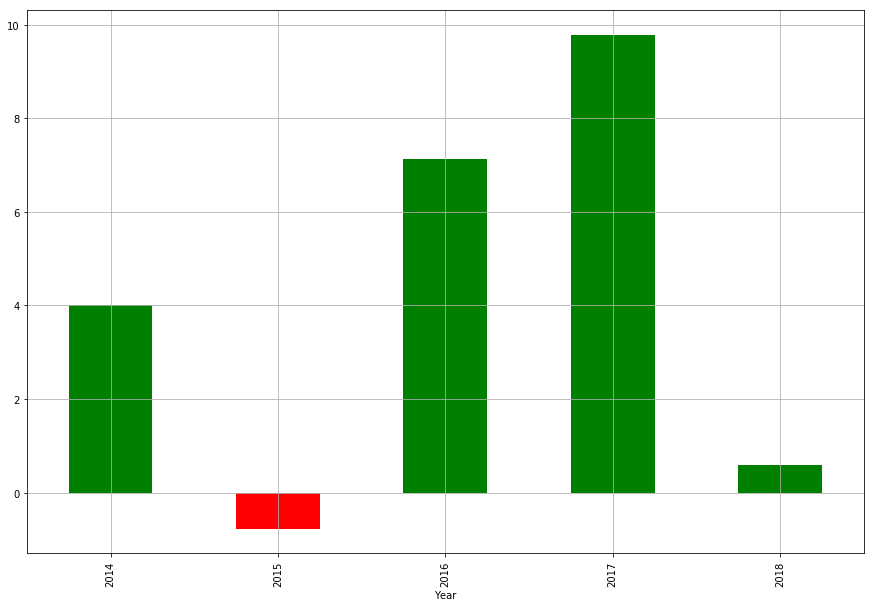

In [13]:
df = monthly_return_table (p_value)
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

# RAAA00

         inception
Symbols           
FFXSX   1999-12-31
FRESX   1999-12-31
VCVSX   1999-12-31
VFIIX   1999-12-31
VGHCX   1999-12-31
VUSTX   1999-12-31
VWEHX   1999-12-31
FIRST BUY DATE = 2000-01-31 00:00:00



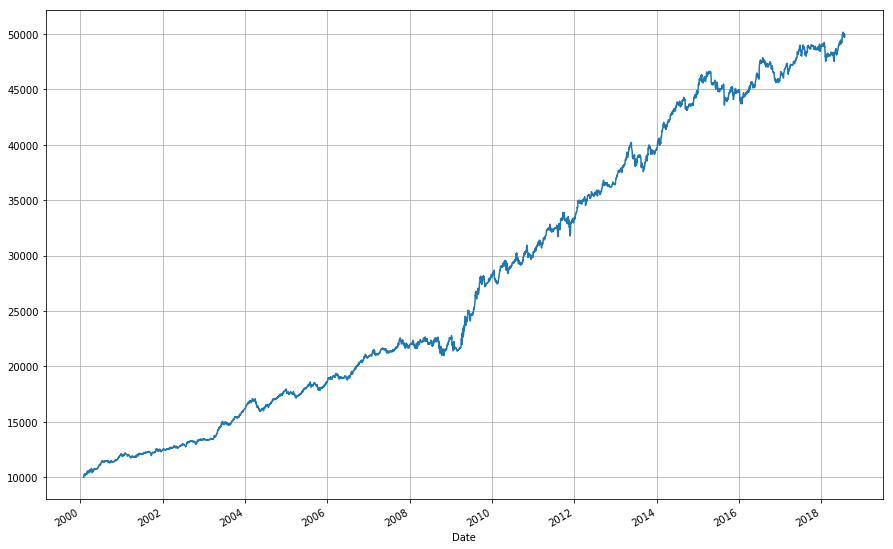

In [14]:
symbols =['VCVSX','VUSTX','VWEHX','VFIIX','VGHCX','FRESX']
cash_proxy = 'VFIIX'
risk_free = 'FFXSX'

rs_lookback = 1
risk_lookback = 1
n_top = 5

# get data
tickers = symbols.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))

data = pd.DataFrame (columns=tickers)

# Define which online source one should use
data_source = 'yahoo'

# We would like all available data from 01/01/2000 until today.
start_date = '2000-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = web.DataReader(tickers, data_source, start_date, end_date)
data = panel_data['Adj Close'].sort_index(ascending=True)
         
inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])

print (inception_dates)

prices = data.copy().dropna()

end_points = endpoints(period='M', trading_days=prices.index)
prices_m = prices.loc[end_points]

returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
absolute_momentum_rule = returns > 0

if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking               
ranked = excess_returns.loc[rebalance_dates][symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

In [15]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 2000-01-31 00:00:00 - 2018-07-27 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
397.39%             1.41  9.07%   -7.41%

Annualized Returns:
mtd    3m     6m     ytd    1y     3y     5y     10y    incep.
-----  -----  -----  -----  -----  -----  -----  -----  --------
0.80%  3.48%  1.05%  1.77%  2.20%  3.34%  5.03%  8.49%  9.07%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.41     1.54       1.31
mean    8.89%    8.87%      8.33%
vol     6.32%    5.76%      6.37%
skew    -0.29    0.27       1.19
kurt    8.36     2.93       1.33
best    3.27%    8.90%      24.31%
worst   -3.30%   -5.06%     0.69%

Drawdowns:
max     avg       # days
------  ------  --------
-7.41%  -0.90%     20.18

Misc:
---------------  -------
avg. up month    1.46%
avg. down month  -1.12%
up year %        100.00%
12m up %         94.81%
-------

In [16]:
show_return_table(p_value)

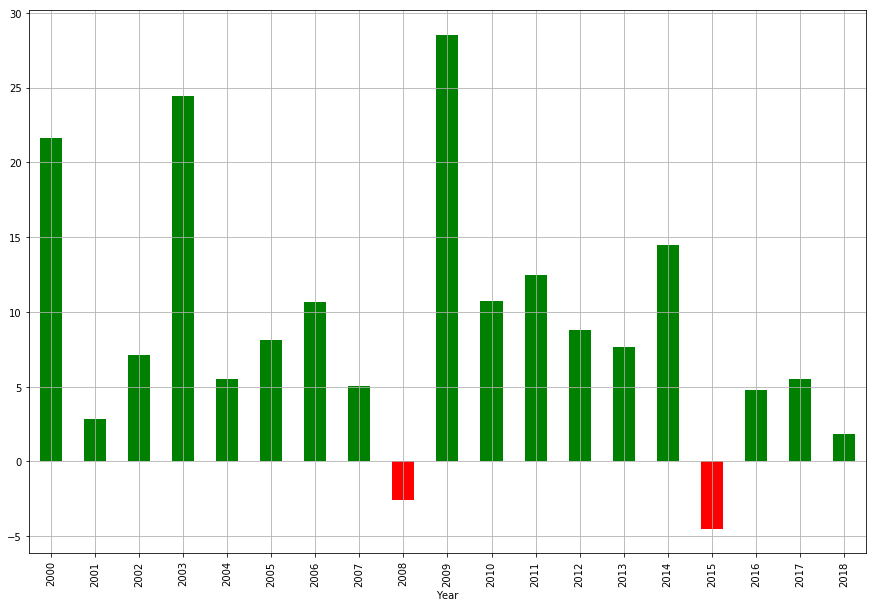

In [17]:
df = monthly_return_table (p_value)
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

# STEP BY STEP BACKTEST

In [18]:
def talib_transform(df, function, lookback):
    '''
    df: DataFrame of ETF prices (daily, monthly, ..)
    function: talib function (eg talib.MA)
    lookback: no of lookback periods (days, months, ..)
    
    example: transform = talib_transform(df, talib.MA, 21)
    '''
    # make sure that TALIB fuction only requires one price!

    try:
        return pd.DataFrame({etf:function(df[etf], lookback) for etf in df.columns},
                columns=df.columns,
                index=df.index).dropna()
    except:
        print('ValueError: Shape of passed values is incorrect!')

In [19]:
def _apply_RAA (self, context, allocations, cash_proxy, *args): 
    excess_returns =  context.algo_data['EMOM']

    tmp1 = [0.5 if excess_returns[asset] > 0 else 0. for asset in allocations.index]

    prices = context.algo_data['price']
    MA = context.algo_data['smma']

    tmp2 = [0.5 if prices[asset] > MA[asset] else 0. for asset in allocations.index]

    dpf = pd.Series([x + y for x, y in zip(tmp1, tmp2)], index=allocations.index)

    new_allocations = allocations * dpf
    new_allocations[cash_proxy] = new_allocations[cash_proxy] + (1 - np.sum(new_allocations))

    record('BOND EXPOSURE', new_allocations[cash_proxy])

    return new_allocations

## Allocations

The RAA Balanced allocation (if fully allocated) is as follows:

MTUM US Momentum	        10%
IWD  US Large Cap Value	    10%
EFA	 International Equities	10%
EFV	 International Value	10%
VNQ	 US Real Estate	        20%
DBC	 Commodities	        20%
IEF	 Int-Term US Treasuries	20%

In [20]:
allocations = {'MTUM':0.1,'IWD':0.1,'EFA':0.1,'EFV':0.1,'VNQ':0.2,'DBC':0.2,'IEF':0.2,'BIL':0.}
symbols =['MTUM','IWD','EFA','EFV','VNQ','DBC','IEF']
cash_proxy = 'CASHX'
risk_free = 'BIL'

rs_lookback = 12
risk_lookback = 12
tx_lookback = 12
n_top = 7


# get data
tickers = symbols.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))

data = pd.DataFrame (columns=tickers)
# Define which online source one should use
data_source = 'yahoo'

# We would like all available data from 01/01/2000 until today.
start_date = '1986-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
multindexed = web.DataReader(tickers, data_source, start_date, end_date)
data = multindexed['Adj Close'].sort_index(ascending=True)
         
inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])


In [21]:
inception_dates

,inception
Symbols,
BIL,2007-05-30
DBC,2006-02-06
EFA,2001-08-27
EFV,2005-08-05
IEF,2002-07-30
IWD,2000-05-26
MTUM,2013-04-18
VNQ,2004-09-29


In [22]:
data[:3]

Symbols,BIL,DBC,EFA,EFV,IEF,IWD,MTUM,VNQ
Date,,,,,,,,
2000-05-26,NaN,NaN,NaN,NaN,NaN,36.880646,NaN,NaN
2000-05-30,NaN,NaN,NaN,NaN,NaN,37.306351,NaN,NaN
2000-05-31,NaN,NaN,NaN,NaN,NaN,37.576321,NaN,NaN


In [23]:
prices = data.copy().dropna()
prices[:5]

Symbols,BIL,DBC,EFA,EFV,IEF,IWD,MTUM,VNQ
Date,,,,,,,,
2013-04-18,90.324089,25.790001,49.706913,40.346104,98.413338,70.782356,47.734619,58.872551
2013-04-19,90.343857,25.730000,50.105377,40.638062,98.359009,71.413010,47.734619,59.779778
2013-04-22,90.343857,25.809999,50.317329,40.873241,98.413338,71.617279,47.734619,59.698776
2013-04-23,90.343857,25.650000,51.029488,41.457142,98.349937,72.425575,48.953300,60.030876
2013-04-24,90.343857,25.930000,51.470345,41.854519,98.395218,72.549927,48.334591,60.160484


In [24]:
end_points = endpoints(period='M', trading_days=prices.index)
prices_m = prices.loc[end_points]
prices_m[:3]

Symbols,BIL,DBC,EFA,EFV,IEF,IWD,MTUM,VNQ
Date,,,,,,,,
2013-04-30,90.324089,26.270000,52.513149,42.868248,98.585472,73.180550,48.597076,60.978611
2013-05-31,90.343857,25.860001,50.927750,41.432816,95.524376,75.134636,48.747059,57.333508
2013-06-28,90.324089,25.129999,49.563499,40.140003,93.092171,74.424057,48.343128,56.197212


In [25]:
[a[1] for a in allocations.items()]

[0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.0]

In [26]:
elligible = pd.DataFrame(allocations, index=prices_m.index, columns=symbols)
elligible[:3]

,MTUM,IWD,EFA,EFV,VNQ,DBC,IEF
Date,,,,,,,
2013-04-30,0.1,0.1,0.1,0.1,0.2,0.2,0.2
2013-05-31,0.1,0.1,0.1,0.1,0.2,0.2,0.2
2013-06-28,0.1,0.1,0.1,0.1,0.2,0.2,0.2


In [27]:
rebalance_dates = prices_m.index

1. At the close on the last trading day of the month, compare the following for each asset class: (1) 12-month return versus the 12-month return of BIL (short-term US Treasuries), and (2) closing price versus the 12-month moving average.

In [28]:
# 12 month returns
returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
returns[:3]

Symbols,MTUM,IWD,EFA,EFV,VNQ,DBC,IEF
Date,,,,,,,
2014-04-30,0.167211,0.207445,0.135096,0.157045,-0.001819,0.005329,-0.042484
2014-05-30,0.210952,0.192588,0.189105,0.211331,0.087114,0.006574,0.006238
2014-06-30,0.246370,0.234698,0.233089,0.264265,0.121673,0.057700,0.030290


In [29]:
# 12 month returns of risk_free etf (BIL)
risk_free_returns = prices_m[risk_free].pct_change(risk_lookback)[risk_lookback:]
risk_free_returns[:3]

Date
2014-04-30   -0.000655
2014-05-30   -0.000873
2014-06-30   -0.000873
Name: BIL, dtype: float64

In [30]:
if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rule1 = lambda x: x > 0
tmp1 = excess_returns.applymap(rule1).astype(int) * 0.5 
tmp1[:5]

Symbols,MTUM,IWD,EFA,EFV,VNQ,DBC,IEF
Date,,,,,,,
2014-04-30,0.5,0.5,0.5,0.5,0.0,0.5,0.0
2014-05-30,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2014-06-30,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2014-07-31,0.5,0.5,0.5,0.5,0.5,0.0,0.5
2014-08-29,0.5,0.5,0.5,0.5,0.5,0.0,0.5


In [31]:
# calculate 12-month moving average.
df = prices_m[symbols]
function = talib.MA
lookback = tx_lookback

MA_prices = talib_transform(df,function,lookback)
MA_prices[:3]

Symbols,MTUM,IWD,EFA,EFV,VNQ,DBC,IEF
Date,,,,,,,
2014-03-31,52.956078,79.814553,54.785556,44.890496,56.379789,25.805000,93.692076
2014-04-30,53.633243,81.079634,55.376748,45.451516,56.370545,25.816667,93.343049
2014-05-30,54.490184,82.285468,56.179307,46.181188,56.786756,25.830833,93.392704


In [32]:
# rule2: prices - MA_prices > 0
rule2 = lambda x: x > 0
tmp2 = (prices_m[symbols] - MA_prices).dropna().applymap(rule2).astype(int) * 0.5 
tmp2[:5]

Symbols,MTUM,IWD,EFA,EFV,VNQ,DBC,IEF
Date,,,,,,,
2014-03-31,0.5,0.5,0.5,0.5,0.5,0.5,0.0
2014-04-30,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2014-05-30,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2014-06-30,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2014-07-31,0.5,0.5,0.5,0.5,0.5,0.0,0.5


In [33]:
RAA_rule = (tmp1 + tmp2).dropna()
RAA_rule[:5]

Symbols,MTUM,IWD,EFA,EFV,VNQ,DBC,IEF
Date,,,,,,,
2014-04-30,1.0,1.0,1.0,1.0,0.5,1.0,0.5
2014-05-30,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-06-30,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-07-31,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2014-08-29,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [25]:
# allocations = 1
# x = 0.
# check if returns > risk_free_returns (x = x + 0.5)
# check if prices_m > MA_prices (x = x + 0.5)
# weights = allocations * x
# weight for CASH = 1 - 

In [80]:
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')
rebalance_dates

DatetimeIndex(['2014-04-30', '2014-05-30', '2014-06-30', '2014-07-31',
               '2014-08-29', '2014-09-30', '2014-10-31', '2014-11-28',
               '2014-12-31', '2015-01-30', '2015-02-27', '2015-03-31',
               '2015-04-30', '2015-05-29', '2015-06-30', '2015-07-31',
               '2015-08-31', '2015-09-30', '2015-10-30', '2015-11-30',
               '2015-12-31', '2016-01-29', '2016-02-29', '2016-03-31',
               '2016-04-29', '2016-05-31', '2016-06-30', '2016-07-29',
               '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
               '2016-12-30', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-28', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-29', '2017-10-31', '2017-11-30',
               '2017-12-29', '2018-01-31', '2018-02-28', '2018-03-29',
               '2018-04-30', '2018-05-31', '2018-06-29', '2018-07-20'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
#####################################################################

In [103]:
weights = (elligible * RAA_rule).dropna()
weights[:3]

,MTUM,IWD,EFA,EFV,VNQ,DBC,IEF
Date,,,,,,,
2014-04-30,0.1,0.1,0.1,0.1,0.1,0.2,0.1
2014-05-30,0.1,0.1,0.1,0.1,0.2,0.2,0.2
2014-06-30,0.1,0.1,0.1,0.1,0.2,0.2,0.2


In [107]:
# downside protection
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 1. - weights.sum(1)
weights[:10]

,MTUM,IWD,EFA,EFV,VNQ,DBC,IEF,CASHX
Date,,,,,,,,
2014-04-30,0.1,0.1,0.10,0.10,0.1,0.2,0.1,0.2
2014-05-30,0.1,0.1,0.10,0.10,0.2,0.2,0.2,0.0
2014-06-30,0.1,0.1,0.10,0.10,0.2,0.2,0.2,0.0
2014-07-31,0.1,0.1,0.10,0.10,0.2,0.0,0.2,0.2
2014-08-29,0.1,0.1,0.10,0.10,0.2,0.0,0.2,0.2
2014-09-30,0.1,0.1,0.05,0.05,0.2,0.0,0.2,0.3
2014-10-31,0.1,0.1,0.05,0.05,0.2,0.0,0.2,0.3
2014-11-28,0.1,0.1,0.00,0.00,0.2,0.0,0.2,0.4
2014-12-31,0.1,0.1,0.00,0.00,0.2,0.0,0.2,0.4


FIRST BUY DATE = 2014-04-30 00:00:00



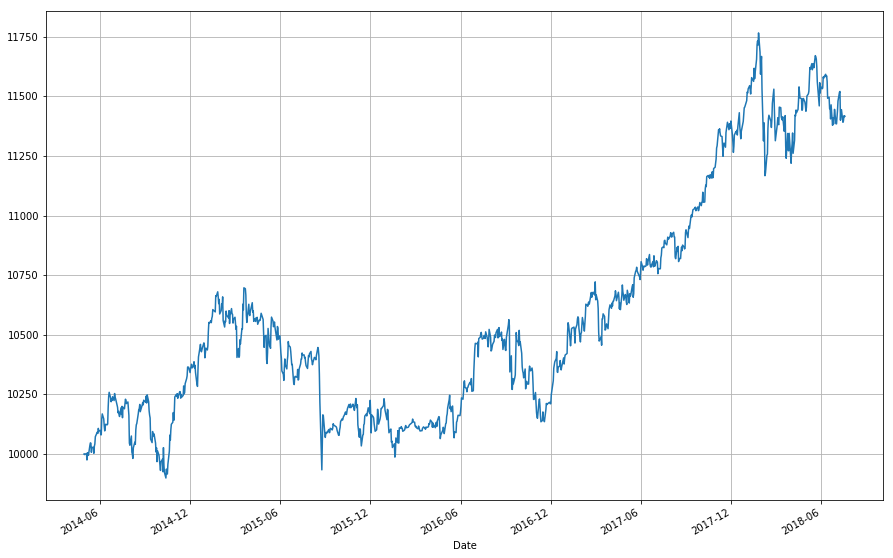

In [108]:
# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

# SCRATCHPAD